In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn


##The goal of this exercise is to understand what makes customers decide to leave telco for competitors. We are interested in developing interpretable models to predict which customers are at risk of churning.##

In [ ]:
!pip install scikit-learn
!pip install pygam

In [ ]:
#Now that we have the dataset import from Kaggle. Let's import the necessary depencies to conduct our analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression
from pygam import LinearGAM, LogisticGAM, PoissonGAM, GammaGAM
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

##Now that we have our dependencies, I'd like to conduct some exploratory analysis to learn about some of our features that dictate churn. More specifically, I'm interested in if the underlying assumptions of linear, logistic and GAM models are met.##

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

#import and read
churn_data=pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(churn_data.head())

print(churn_data.info())
print(churn_data.shape) #Curious about data structure
print(churn_data.describe(include="all")) #I want basic statistics

Path to dataset files: /kaggle/input/telco-customer-churn
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  Te

##The above shows the dataset outlines multiple features that determine whether or no a customer is likely to remain with the company. It tracks 20 features with the last column, churn, being the target variable. We see that amongst the 7043 customers that the mean tenure is almost three years with the longest being 6 years! We also see that 25% of customers are new to the company we may suggest that they are aquiring more or there is high Churn. There also seems to be tiered charging system as well.

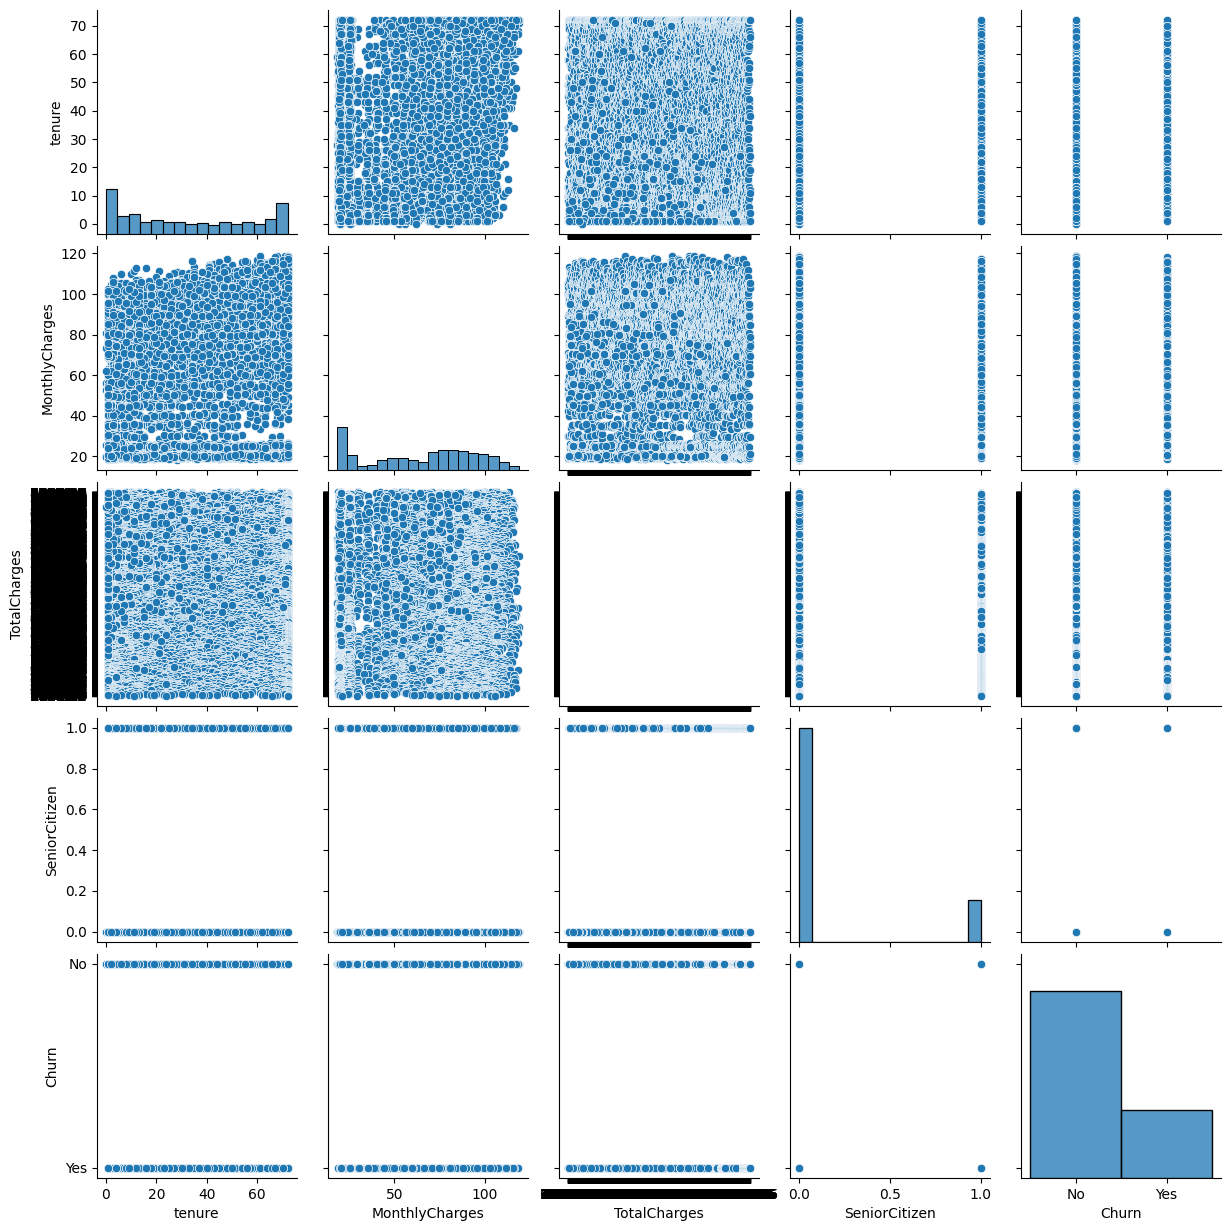

In [ ]:
#Let's compare some variables against one another.
sns.pairplot(churn_data,vars=['tenure','MonthlyCharges','TotalCharges','SeniorCitizen','Churn'])

##Evaluating churn, tenure, senior status and monthly charges within a pairplot, we see there are non linear relationships amongst different features. Monthly charges and tenure seem to have even distributions so no strong linear relationships seem to exist.

In [ ]:

churn_data['TotalCharges'] = pd.to_numeric(churn_data['TotalCharges'], errors='coerce')
churn_data.dropna(subset=['TotalCharges'], inplace=True)

# Select categorical columns for one-hot encoding (excluding 'customerID' )
categorical_cols = churn_data.select_dtypes(include='object').columns.tolist()
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn') # Exclude target variable if it's an object

# Perform one-hot encoding
churn_data_encoded = pd.get_dummies(churn_data, columns=categorical_cols, drop_first=True)

# Display the first few rows of the encoded dataframe and its info to check the result
display(churn_data_encoded.head())
print(churn_data_encoded.info())

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,0,1,29.85,29.85,No,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False
1,5575-GNVDE,0,34,56.95,1889.50,No,True,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2,3668-QPYBK,0,2,53.85,108.15,Yes,True,False,False,True,...,False,False,False,False,False,False,True,False,False,True
3,7795-CFOCW,0,45,42.30,1840.75,No,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,9237-HQITU,0,2,70.70,151.65,Yes,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   customerID                             7032 non-null   object 
 1   SeniorCitizen                          7032 non-null   int64  
 2   tenure                                 7032 non-null   int64  
 3   MonthlyCharges                         7032 non-null   float64
 4   TotalCharges                           7032 non-null   float64
 5   Churn                                  7032 non-null   object 
 6   gender_Male                            7032 non-null   bool   
 7   Partner_Yes                            7032 non-null   bool   
 8   Dependents_Yes                         7032 non-null   bool   
 9   PhoneService_Yes                       7032 non-null   bool   
 10  MultipleLines_No phone service         7032 non-null   bool   
 11  MultipleL

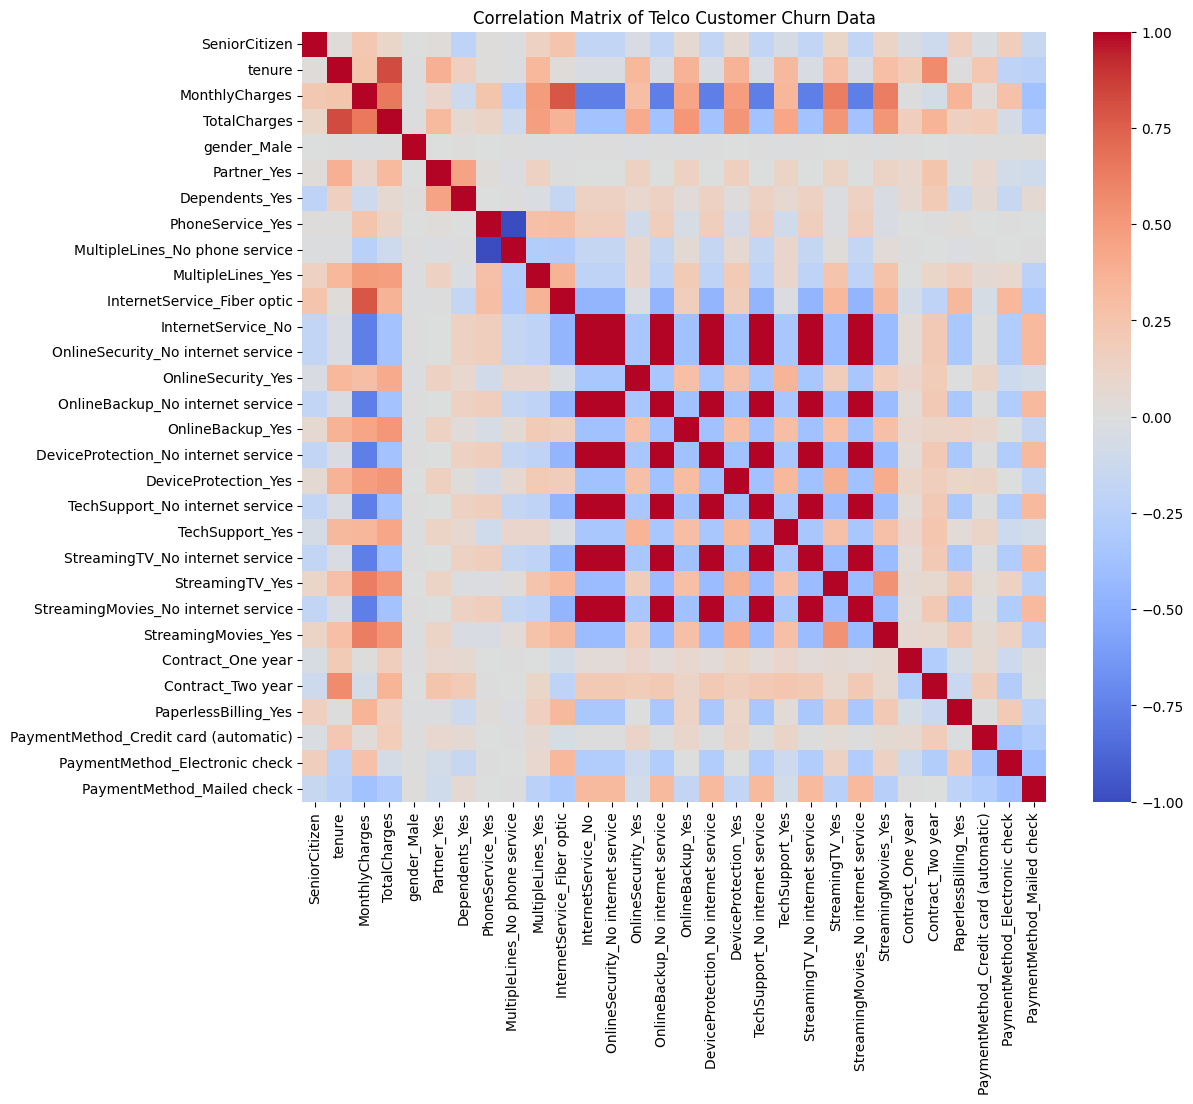

In [ ]:
# Exclude 'customerID' and 'Churn' from the correlation calculation
df_corr = churn_data_encoded.drop(columns=['customerID', 'Churn']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(df_corr, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Telco Customer Churn Data')
plt.show()

##The heatmap above demonstrates that are correlations between multiple relationships suggesting a non-linear model may be the more appropriate option.The collinear features are logical; it would make sense that those that do not have internet also wouldn't have streaming services. This makes the problem not as straightforward as one would think.

In [ ]:
#Let's go ahead and train out logistic regressiona and linear regression models


churn_data['TotalCharges'] = pd.to_numeric(churn_data['TotalCharges'], errors='coerce')
churn_data.dropna(subset=['TotalCharges'], inplace=True)

# Select categorical columns for one-hot encoding (excluding 'customerID' )
categorical_cols = churn_data.select_dtypes(include='object').columns.tolist()
if 'customerID' in categorical_cols:
    categorical_cols.remove('customerID')
if 'Churn' in categorical_cols:
    categorical_cols.remove('Churn') # Exclude target variable if it's an object

# Perform one-hot encoding
churn_data_encoded = pd.get_dummies(churn_data, columns=categorical_cols, drop_first=True)

# Convert 'Churn' column to numerical (1 for 'Yes', 0 for 'No')
churn_data_encoded['Churn'] = churn_data_encoded['Churn'].map({'Yes': 1, 'No': 0})
scaler = StandardScaler()

x=churn_data_encoded.drop(columns=['customerID','Churn'])
x=scaler.fit_transform(x)
y=churn_data_encoded['Churn']
Regression_models=[LinearRegression(),LogisticRegression()]

def train_and_evaluate(model):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    if isinstance(model, LinearRegression):
        mse=mean_squared_error(y_test,y_pred)
        r2=r2_score(y_test,y_pred)
        print(f"Linear Regression Results:")
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"R-squared: {r2:.4f}")
    if isinstance(model, LogisticRegression):
        accuracy=accuracy_score(y_test,y_pred)
        conf_matrix=confusion_matrix(y_test,y_pred)
        class_report=classification_report(y_test,y_pred)
        print(f"\nLogistic Regression Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}")
        print(f"Classification Report:\n{class_report}")

# Train and evaluate the models
for model in Regression_models:
    train_and_evaluate(model)

Linear Regression Results:
Mean Squared Error: 0.1459
R-squared: 0.2522

Logistic Regression Results:
Accuracy: 0.7875
Confusion Matrix:
[[915 118]
 [181 193]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.52      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



##The above demonstrates that the linearity does not exist in this data set and there are non linearities that need to be accounted for. The Logisitic regression model has a much higher accuracy predicting which customers will remain but a very low recall for predicting which customers will, in fact, churn. It seems that both regression models fail to capture the more complex relationships between features which necessitates exploring GAM models.

GAM Accuracy: 0.8107
Confusion Matrix:
[[4677  486]
 [ 845 1024]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88      5163
           1       0.68      0.55      0.61      1869

    accuracy                           0.81      7032
   macro avg       0.76      0.73      0.74      7032
weighted avg       0.80      0.81      0.80      7032



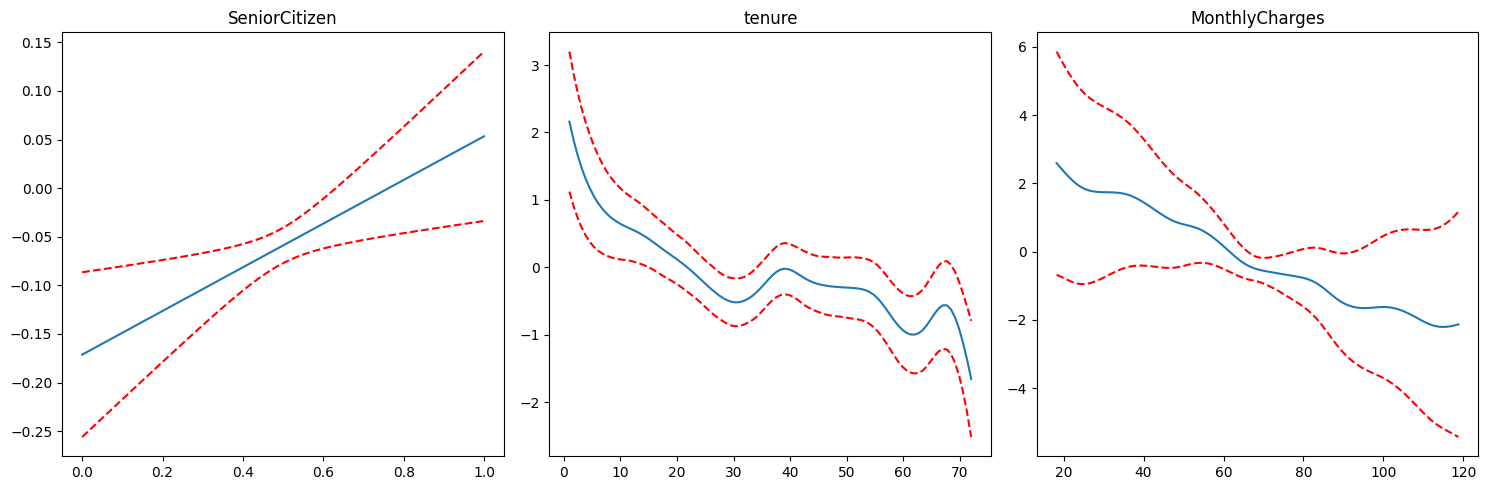

In [ ]:
from pygam import LogisticGAM, s, f
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

x, y = churn_data_encoded.drop(columns=['customerID','Churn']), churn_data_encoded['Churn']
x_np = x.astype(float).values
y = y.astype(int)

# Create GAM terms
gam_terms = s(0)
for i in range(1, x_np.shape[1]):
    gam_terms += s(i)

gam = LogisticGAM(gam_terms).fit(x_np, y)

# *The above code snippet was generated using Claude Sonnet 4 on 08/26/25 at 11:13p*
# New to GAM so needed to see some examples

print(f"GAM Accuracy: {gam.accuracy(x_np, y):.4f}")
y_pred = gam.predict(x_np)
print(f"Confusion Matrix:\n{confusion_matrix(y, y_pred)}")
print(f"Classification Report:\n{classification_report(y, y_pred)}")

# Plot first 3 features
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)
    axs[i].plot(XX[:, i], pdep)
    axs[i].plot(XX[:, i], confi, c='r', ls='--')
    axs[i].set_title(x.columns[i])
plt.tight_layout()
plt.show()



##We see above how the spline functions are able to smooth out and capture some of the potentially more complex relationships between features; the use of GAMS allows for a higher level of accuracy without the need of uninterpretable blackblox models.Although it is marginally better than logistic regression at determining churn, it still provides adequate accuracy for this telecommunications company to make informed decisions to forecast customer loyalty. I would also recommend the company explore other options such as SVM to improve accuracy. But given the above, the logistic GAM is the most apt model to provide some intpretability and capturing some more complex features relationships.